In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("Datasets/pulsar_data_train.csv")

In [3]:
df.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,121.156250,48.372971,0.375485,-0.013165,3.168896,18.399367,7.449874,65.159298,0.0
1,76.968750,36.175557,0.712898,3.388719,2.399666,17.570997,9.414652,102.722975,0.0
2,130.585938,53.229534,0.133408,-0.297242,2.743311,22.362553,8.508364,74.031324,0.0
3,156.398438,48.865942,-0.215989,-0.171294,17.471572,NaN,2.958066,7.197842,0.0
4,84.804688,36.117659,0.825013,3.274125,2.790134,20.618009,8.405008,76.291128,0.0


In [4]:
df.shape

(12528, 9)

## Data Checks to perform
- Check Missing values
- Check Duplicates
- Check data type
- Check the number of unique values of each column
- Check statistics of data set
- Check various categories present in the different categorical column

# Check Missing Values

In [5]:
df.isna().sum()

 Mean of the integrated profile                     0
 Standard deviation of the integrated profile       0
 Excess kurtosis of the integrated profile       1735
 Skewness of the integrated profile                 0
 Mean of the DM-SNR curve                           0
 Standard deviation of the DM-SNR curve          1178
 Excess kurtosis of the DM-SNR curve                0
 Skewness of the DM-SNR curve                     625
target_class                                        0
dtype: int64

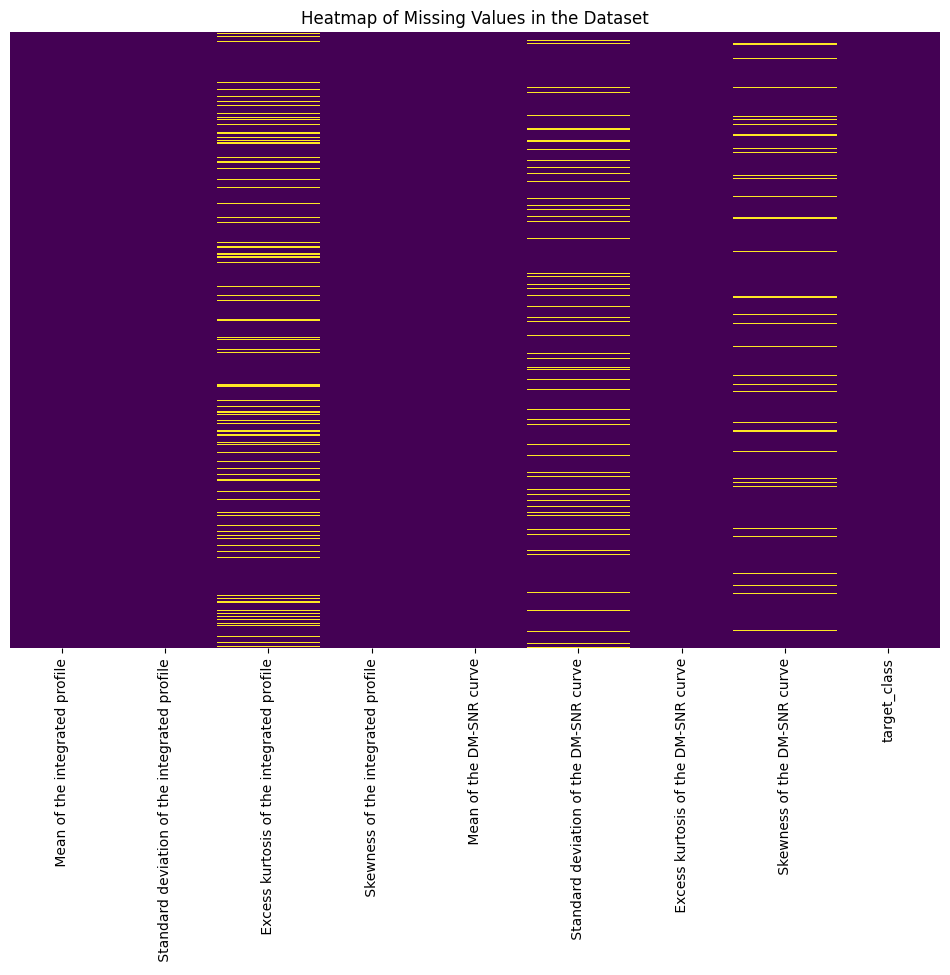

In [11]:
# Create a mask for missing values
missing_mask = df.isnull()

# Plotting the missing values heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(missing_mask, cbar=False, yticklabels=False, cmap='viridis')
plt.title('Heatmap of Missing Values in the Dataset')
plt.show()




The heatmap of missing values shows where in the dataset the missing values are located, but it doesn't reveal a clear pattern. The missing values are spread out and not concentrated in specific rows or blocks, which might suggest that the data could be missing at random.

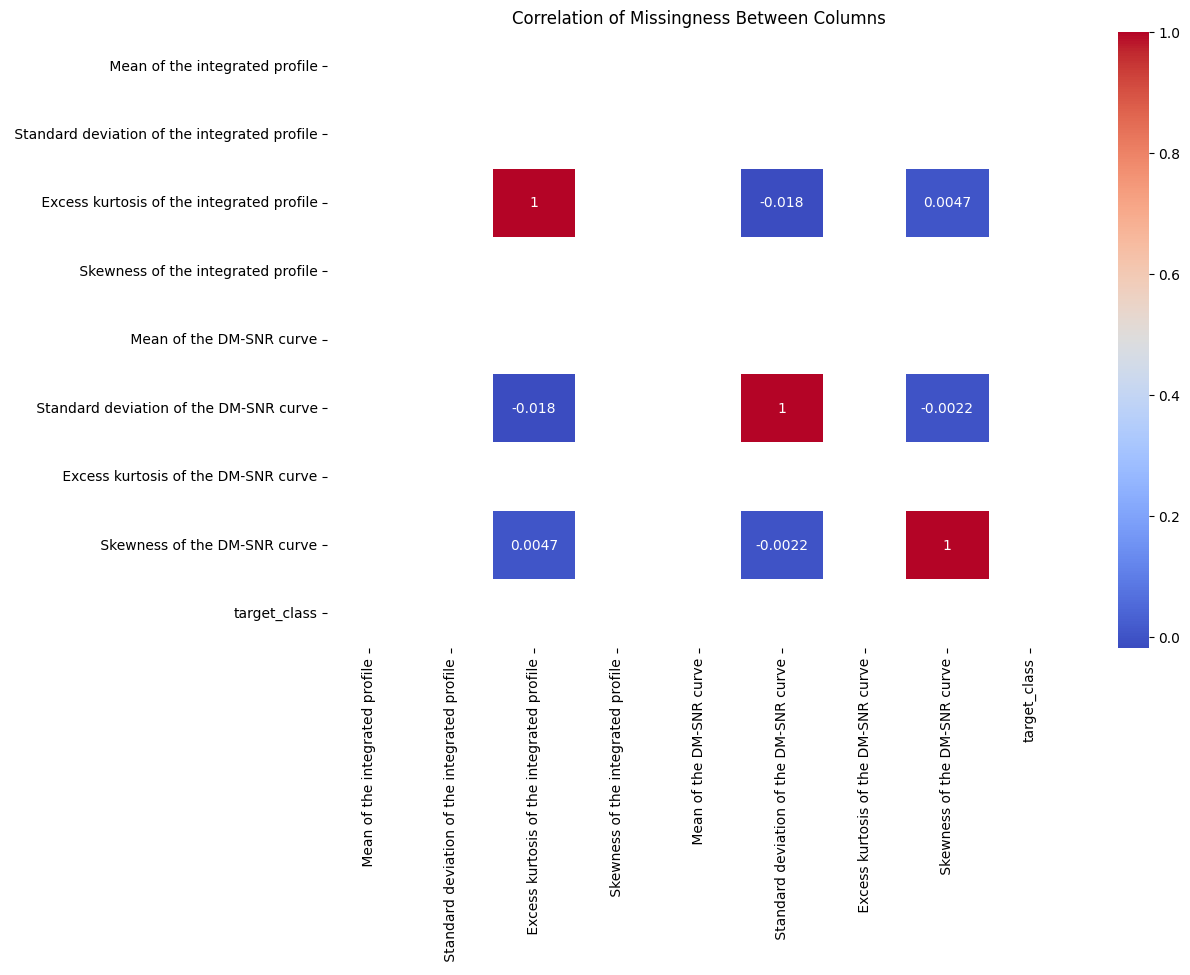

In [12]:
# Calculating the correlation of missingness between columns
# We are using the mask where True is 1 and False is 0, hence we can calculate the correlation between these binary values
missing_corr = missing_mask.corr()

# Displaying the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(missing_corr, annot=True, cmap='coolwarm')
plt.title('Correlation of Missingness Between Columns')
plt.show()

The correlation heatmap of missingness between columns indicates that there is no strong correlation between the missingness of one column and another. Most correlations are very low, suggesting that the presence or absence of data in one column does not imply the presence or absence of data in another.

In [13]:
# Display the percentage of missing values in each column
missing_percentage = df.isnull().mean() * 100
missing_percentage

 Mean of the integrated profile                   0.000000
 Standard deviation of the integrated profile     0.000000
 Excess kurtosis of the integrated profile       13.848978
 Skewness of the integrated profile               0.000000
 Mean of the DM-SNR curve                         0.000000
 Standard deviation of the DM-SNR curve           9.402937
 Excess kurtosis of the DM-SNR curve              0.000000
 Skewness of the DM-SNR curve                     4.988825
target_class                                      0.000000
dtype: float64

The percentage of missing values in each column is as follows:

- Excess kurtosis of the integrated profile: 13.85%
- Standard deviation of the DM-SNR curve: 9.40%
- Skewness of the DM-SNR curve: 4.99%

Becuase there is no pattern in the missing values of these columns, I assume it is not safe to delete any rows from these columns.

So, I am going to implement imputation. 

For it, i need to check data distribution. Lets do it. 

In [20]:
# Calculating the skewness and kurtosis for the columns with missing values
columns_with_missing_values = [' Excess kurtosis of the integrated profile',
                               ' Standard deviation of the DM-SNR curve',
                               ' Skewness of the DM-SNR curve']

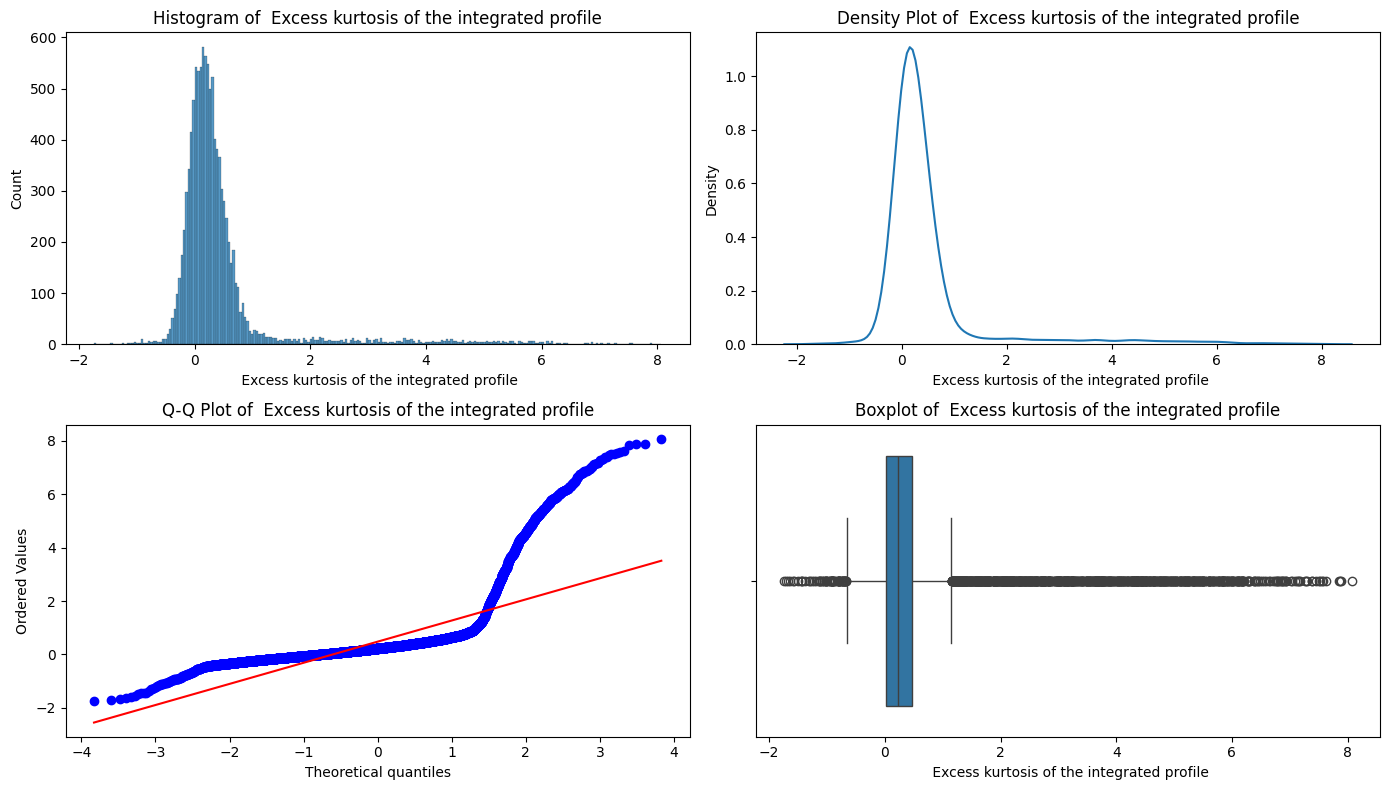

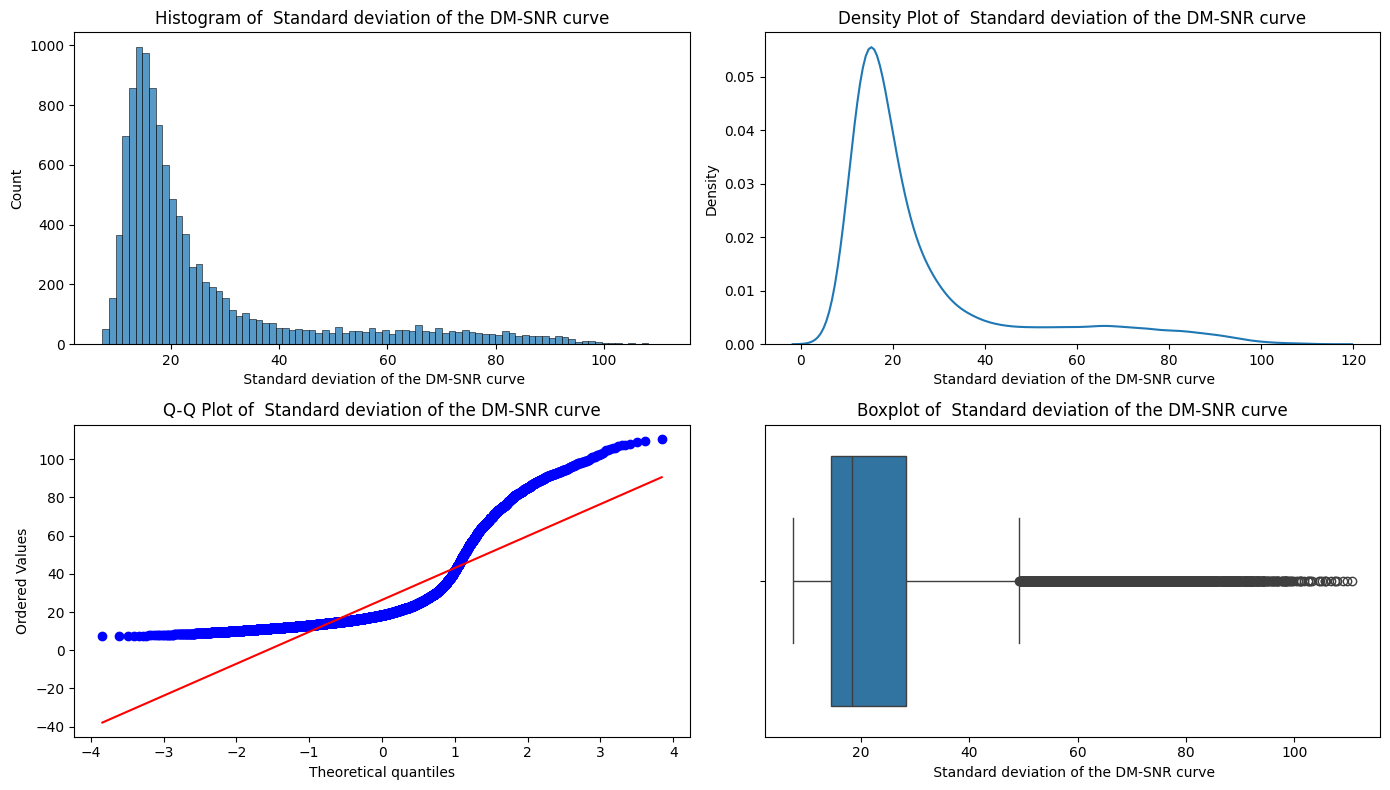

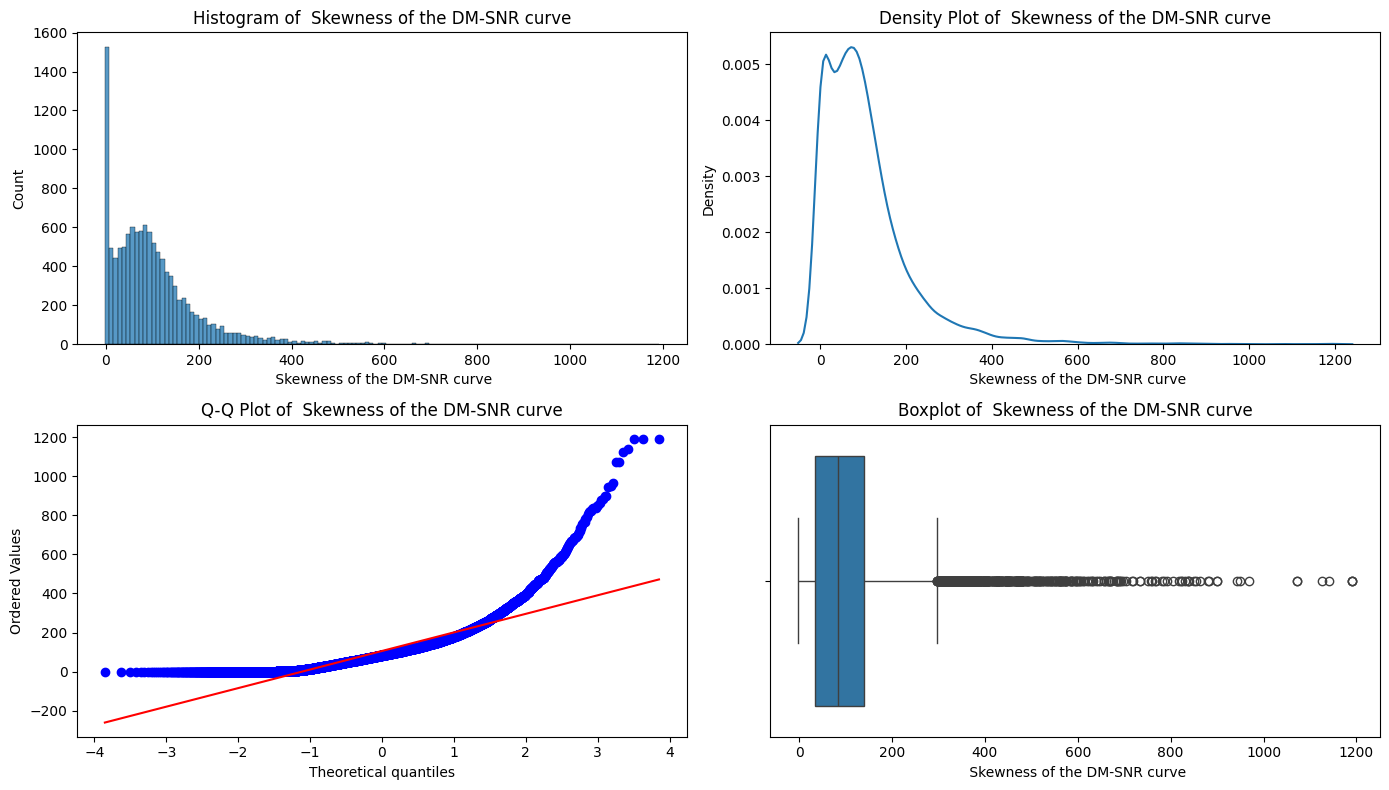

In [21]:
from scipy import stats

# Defining a function to plot histograms, density plots, and Q-Q plots
def plot_distribution(column_name):
    # Remove NaN values for plotting
    data = df[column_name].dropna()
    
    # Set up the matplotlib figure
    fig, axs = plt.subplots(2, 2, figsize=(14, 8))

    # Histogram
    sns.histplot(data, kde=False, ax=axs[0, 0])
    axs[0, 0].set_title(f'Histogram of {column_name}')

    # Density Plot
    sns.kdeplot(data, ax=axs[0, 1])
    axs[0, 1].set_title(f'Density Plot of {column_name}')

    # Q-Q plot
    stats.probplot(data, dist="norm", plot=axs[1, 0])
    axs[1, 0].set_title(f'Q-Q Plot of {column_name}')

    # Boxplot
    sns.boxplot(x=data, ax=axs[1, 1])
    axs[1, 1].set_title(f'Boxplot of {column_name}')

    plt.tight_layout()
    plt.show()

# Plotting distributions
for column in columns_with_missing_values:
    plot_distribution(column)




The visual and statistical tests suggest the following for the columns with missing values:

1. Excess kurtosis of the integrated profile: 
- Histogram and Density Plot: The distribution does not appear to be normal; it is heavily skewed.
- Q-Q Plot: The data points do not lie on the line, indicating that the distribution deviates from normality.
- Shapiro-Wilk Test: The p-value is 0.0, which is below the common alpha level of 0.05, leading us to reject the null hypothesis and conclude that the data is not normally distributed.

2. Standard deviation of the DM-SNR curve:

- The distribution is also skewed, as seen in the Histogram and Density Plot.
- The Q-Q Plot shows deviations from the line, especially in the tails.
- The Shapiro-Wilk Test confirms non-normality with a p-value of 0.0.

3. Skewness of the DM-SNR curve:

- Again, the Histogram and Density Plot indicate a skewed distribution.
- The Q-Q Plot shows a deviation from normality.
- The Shapiro-Wilk Test p-value of 0.0 indicates the data is not normally distributed.

In [22]:
# Shapiro-Wilk Test
shapiro_results = {}
for column in columns_with_missing_values:
    shapiro_test_stat, shapiro_p_value = stats.shapiro(df[column].dropna())
    shapiro_results[column] = {'Shapiro-Wilk Test Statistic': shapiro_test_stat, 'p-value': shapiro_p_value}

shapiro_results

{' Excess kurtosis of the integrated profile': {'Shapiro-Wilk Test Statistic': 0.5524154287515255,
  'p-value': 6.711449339215708e-97},
 ' Standard deviation of the DM-SNR curve': {'Shapiro-Wilk Test Statistic': 0.7271921650141079,
  'p-value': 1.9571254194167016e-86},
 ' Skewness of the DM-SNR curve': {'Shapiro-Wilk Test Statistic': 0.7836843739303044,
  'p-value': 2.742153510650096e-82}}

From the visualizations, Shapiro-Wilk Test, and p-value, we can conclude that these columns's data is skewed. So, for imputation we have the following options:

- Median Imputation
- Model based imputation

I would prefer Model-based imputation becuase of following characteristics of the of missing values columns:

- The missing data is not a large percentage of the dataset (ranging from about 5% to 14% missing).
- The data appears to be non-normally distributed and skewed.
- We likely have complex relationships in our data given the scientific nature of the dataset.

Multiple Imputation by Chained Equations (MICE) is the best imputation method for our dataset because it is versatile and can handle the complexity and potential non-linear relationships in our data.


In [24]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Initialize the imputer
df_imputed = IterativeImputer()
# Fit and transform the data
df_imputed = pd.DataFrame(df_imputed.fit_transform(df), columns=df.columns)

# Display the updated dataframe
df_imputed.to_csv('Datasets/pulsar_data_train_imputed.csv', index=False)

In [25]:
df_imputed.isna().sum()

 Mean of the integrated profile                  0
 Standard deviation of the integrated profile    0
 Excess kurtosis of the integrated profile       0
 Skewness of the integrated profile              0
 Mean of the DM-SNR curve                        0
 Standard deviation of the DM-SNR curve          0
 Excess kurtosis of the DM-SNR curve             0
 Skewness of the DM-SNR curve                    0
target_class                                     0
dtype: int64

Check Duplicates

In [6]:
df.duplicated().sum()

0

Check Data Types

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12528 entries, 0 to 12527
Data columns (total 9 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0    Mean of the integrated profile                12528 non-null  float64
 1    Standard deviation of the integrated profile  12528 non-null  float64
 2    Excess kurtosis of the integrated profile     10793 non-null  float64
 3    Skewness of the integrated profile            12528 non-null  float64
 4    Mean of the DM-SNR curve                      12528 non-null  float64
 5    Standard deviation of the DM-SNR curve        11350 non-null  float64
 6    Excess kurtosis of the DM-SNR curve           12528 non-null  float64
 7    Skewness of the DM-SNR curve                  11903 non-null  float64
 8   target_class                                   12528 non-null  float64
dtypes: float64(9)
memory usage: 881.0 KB


Checking the Number of Unique values of each column

In [8]:
df.nunique()

 Mean of the integrated profile                   7192
 Standard deviation of the integrated profile    12510
 Excess kurtosis of the integrated profile       10793
 Skewness of the integrated profile              12528
 Mean of the DM-SNR curve                         7224
 Standard deviation of the DM-SNR curve          11348
 Excess kurtosis of the DM-SNR curve             12526
 Skewness of the DM-SNR curve                    11901
target_class                                         2
dtype: int64

Check Statistics of the dataset

In [9]:
df.describe()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
count,12528.000000,12528.000000,10793.000000,12528.000000,12528.000000,11350.000000,12528.000000,11903.000000,12528.000000
mean,111.041841,46.521437,0.478548,1.778431,12.674758,26.351318,8.333489,105.525779,0.092034
std,25.672828,6.801077,1.064708,6.208450,29.613230,19.610842,4.535783,107.399585,0.289085
min,5.812500,24.772042,-1.738021,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.871094,42.362222,0.024652,-0.188142,1.910535,14.404353,5.803063,35.199899,0.000000
50%,115.183594,46.931022,0.223678,0.203317,2.792642,18.412402,8.451097,83.126301,0.000000
75%,127.109375,50.979103,0.473125,0.932374,5.413253,28.337418,10.727927,139.997850,0.000000
max,189.734375,91.808628,8.069522,68.101622,222.421405,110.642211,34.539844,1191.000837,1.000000
